In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = 'cifar-10/trainLabels.csv'
test_csv_file = 'cifar-10/sampleSubmission.csv'
train_folder = 'cifar-10/train/'
test_folder = 'cifar-10/test'

def parse_csv_file(filepath, folder):
    """Parse csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:] # 去掉header
    for line in lines:
        images_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, images_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_lables_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

import pprint
pprint.pprint(train_lables_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_lables_info), len(test_csv_info))

[('cifar-10/train/1.png', 'frog'),
 ('cifar-10/train/2.png', 'truck'),
 ('cifar-10/train/3.png', 'truck'),
 ('cifar-10/train/4.png', 'deer'),
 ('cifar-10/train/5.png', 'automobile')]
[('cifar-10/test/1.png', 'cat'),
 ('cifar-10/test/2.png', 'cat'),
 ('cifar-10/test/3.png', 'cat'),
 ('cifar-10/test/4.png', 'cat'),
 ('cifar-10/test/5.png', 'cat')]
50000 300000


In [3]:
# 将训练集合进行数据切分，切分为训练集和验证集
train_df = pd.DataFrame(train_lables_info[0:45000])
valid_df = pd.DataFrame(train_lables_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())


               filepath       class
0  cifar-10/train/1.png        frog
1  cifar-10/train/2.png       truck
2  cifar-10/train/3.png       truck
3  cifar-10/train/4.png        deer
4  cifar-10/train/5.png  automobile
                   filepath       class
0  cifar-10/train/45001.png       horse
1  cifar-10/train/45002.png  automobile
2  cifar-10/train/45003.png        deer
3  cifar-10/train/45004.png  automobile
4  cifar-10/train/45005.png    airplane
              filepath class
0  cifar-10/test/1.png   cat
1  cifar-10/test/2.png   cat
2  cifar-10/test/3.png   cat
3  cifar-10/test/4.png   cat
4  cifar-10/test/5.png   cat


In [4]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

# 使用flow_from_dataframe进行数据导入
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [5]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                       activation='relu',
                       input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(), # 模型比较深，为了加快训练速度
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

# 因为class_mode = "sparse"
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

In [7]:
epochs = 20
history = model.fit_generator(train_generator,
                             steps_per_epoch = train_num// batch_size,
                             epochs = epochs,
                             validation_data = valid_generator,
                             validation_steps = valid_num // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1406/1406 [==============================] - 54s 38ms/step - loss: 1.8512 - accuracy: 0.3518 - val_loss: 1.8167 - val_accuracy: 0.3974
Epoch 2/20
1406/1406 [==============================] - 53s 38ms/step - loss: 1.4345 - accuracy: 0.4828 - val_loss: 1.6134 - val_accuracy: 0.4722
Epoch 3/20
1406/1406 [==============================] - 54s 38ms/step - loss: 1.2376 - accuracy: 0.5597 - val_loss: 1.3966 - val_accuracy: 0.5553
Epoch 4/20
1406/1406 [==============================] - 54s 38ms/step - loss: 1.0859 - accuracy: 0.6217 - val_loss: 1.2726 - val_accuracy: 0.5793
Epoch 5/20
1406/1406 [==============================] - 54s 38ms/step - loss: 0.9617 - accuracy: 0.6684 - val_loss: 0.8898 - val_accuracy: 0.7192
Epoch 6/20
1406/1406 [==============================] - 54s 38ms/step - loss: 0.8640 - accuracy: 0.7040 - val_loss: 1.1014 - val_accuracy: 0.6821
Epoch 7/20
1406/1406 [==========================

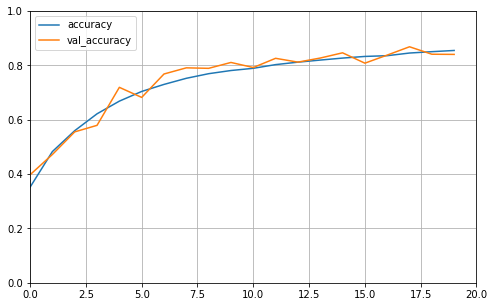

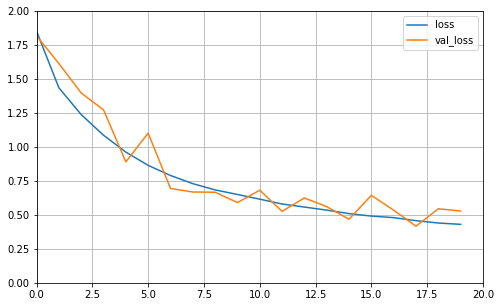

In [8]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [9]:
# 测试集测试
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory='./',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    calss_mode = "sparse"
)
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [11]:
test_predict = model.predict(test_generator)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d_1/Relu (defined at <ipython-input-10-39f6cad1c969>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_66071]

Function call stack:
predict_function


In [ ]:
print(test_predict.shape)

In [ ]:
print(test_predict[0:5])

In [ ]:
test_predict_class_indices = np.argmax(test_predict, axis=1)

In [ ]:
test_predict_class = [class_names[index] for index in test_predict_class_indices]

In [ ]:
print(test_predict_class[:5])